In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data preprocessing

In [3]:
df = pd.read_csv("parkingLot.csv")
df

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2
106690,MHVY8418,2024-11-14 00:00:00,2
106691,MHSR8102,2024-11-14 00:00:00,2
106692,MHQG5264,2024-11-14 00:00:00,2


In [4]:
df['timestamp'] = df['timestamp           '].str.upper().astype('string')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['vehicle_no'] = df['vehicle_no '].str.strip()
df = df.drop('vehicle_no ', axis=1)
df = df.drop('timestamp           ', axis=1)
df = df.sort_values(by='timestamp')
df_preprocessed = df
df

,camera_id,timestamp,vehicle_no
0,1,2024-09-12 05:00:00,MHUN7063
21,1,2024-09-12 05:00:00,MHMY1867
20,1,2024-09-12 05:00:00,MHZF8417
19,1,2024-09-12 05:00:00,MHFU6425
18,1,2024-09-12 05:00:00,MHHB4038
...,...,...,...
106675,2,2024-11-14 00:00:00,MHEV1001
106674,2,2024-11-14 00:00:00,MHGL7893
106692,2,2024-11-14 00:00:00,MHQG5264
106682,2,2024-11-14 00:00:00,MHBB9719


### Forecasting the number of vehicles entering

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

entries_df = df[df['camera_id'] == 1]

vehicles_per_day = entries_df.groupby('date')['vehicle_no'].count()
vehicles_per_day

date
2024-09-12     886
2024-09-13     809
2024-09-14     925
2024-09-15    1073
2024-09-16     843
              ... 
2024-11-09     906
2024-11-10     944
2024-11-11     828
2024-11-12     806
2024-11-13     781
Name: vehicle_no, Length: 63, dtype: int64

#### MASE and MAPE

In [6]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MASE(y_true, y_pred, y_train):
    mae = mean_absolute_error(y_true, y_pred)
    naive_forecast = np.roll(y_train, 1)[1:]  
    naive_mae = mean_absolute_error(y_train[1:], naive_forecast)
    mase = mae / naive_mae
    return mase

We used the dataset initially provided, it had no missing values so we have used the following method for outlier smoothning

### Plot before smoothning

<Axes: xlabel='date'>

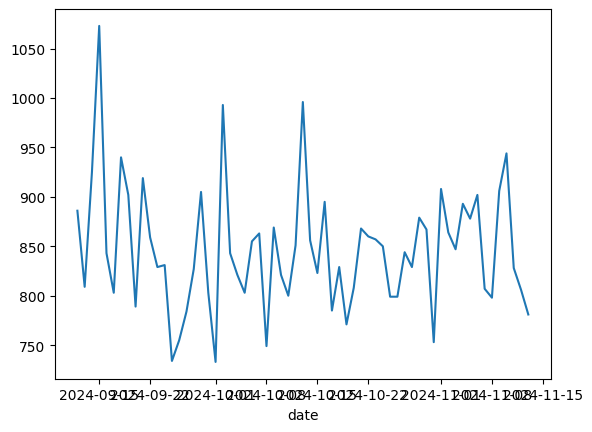

In [7]:
vehicles_per_day.plot(kind='line')

#### 1) Removing the data days which were out of the 15 to 85 percentile range

date
2024-09-12    886
2024-09-13    809
2024-09-16    843
2024-09-17    803
2024-09-19    902
Name: vehicle_no, dtype: int64

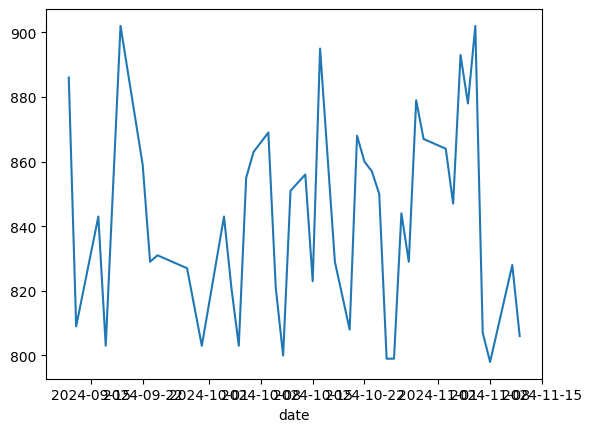

In [8]:

vehicles_per_day_no_outliers = vehicles_per_day[vehicles_per_day.between(vehicles_per_day.quantile(.15), vehicles_per_day.quantile(.85))]
vehicles_per_day_no_outliers.plot(kind='line')

vehicles_per_day_no_outliers.head()

#### 2) Replacing the datapoints which lied out of the 15-85 percentile range with 7 days rolling mean

date
2024-09-12    886.0
2024-09-13    809.0
2024-09-16    843.0
2024-09-17    803.0
2024-09-18    897.0
Name: vehicle_no, dtype: float64

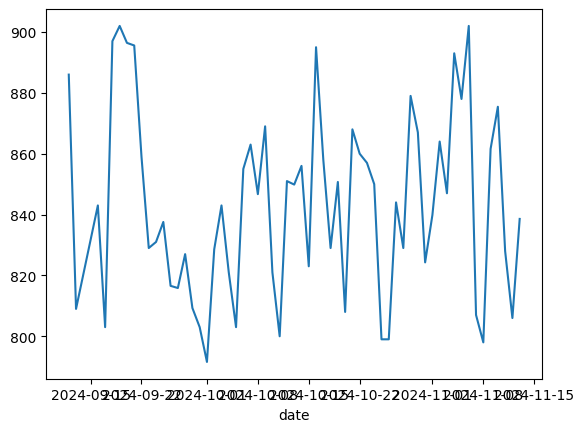

In [9]:

lower_bound = vehicles_per_day.quantile(0.15)
upper_bound = vehicles_per_day.quantile(0.85)

rolling_mean = vehicles_per_day.rolling(window=7).mean()

vehicles_per_day_smoothed = vehicles_per_day.copy()
vehicles_per_day_smoothed[(vehicles_per_day < lower_bound) | (vehicles_per_day > upper_bound)] = rolling_mean

vehicles_per_day_smoothed = vehicles_per_day_smoothed.dropna()

vehicles_per_day_smoothed.plot(kind='line')
vehicles_per_day_smoothed.head()

### Now training the model on each of the above dataset

#### 1) Dataset in which outliers are deleted

In [10]:
import statsmodels.api as sm

X = vehicles_per_day_no_outliers.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

In [11]:
history = [x for x in train]
predictions1 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions1.append(yhat)
    obs = test[t]
    history.append(obs)
print(mean_absolute_error(test, predictions1))

34.27714994889939


In [13]:
print("MAPE: ", mean_absolute_percentage_error(test, predictions1))
print("MASE: ", MASE(test, predictions1, train))

MAPE:  4.037368277359831
MASE:  1.060118039656682


#### 2) Dataset in which outliers are replaced with rolling mean

In [14]:
X = vehicles_per_day_smoothed.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

In [15]:
history = [x for x in train]
predictions1 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions1.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
print(mean_absolute_error(test, predictions1))

27.904548289099598


In [16]:
print("MAPE: ", mean_absolute_percentage_error(test, predictions1))
print("MASE: ", MASE(test, predictions1, train))

MAPE:  3.292026599965158
MASE:  1.0523379627594873


# B part

####
To get around the missing and sometimes wrong data provided by camera, we used 2 strategies here,
1) Removing the values that occur odd number of times in a single day
2) Matching the enteries with exit data and for the records we cannot find entry we replace their duration with forward filling

In [17]:
df = df_preprocessed
df.head()

,camera_id,timestamp,vehicle_no,date
0,1,2024-09-12 05:00:00,MHUN7063,2024-09-12
21,1,2024-09-12 05:00:00,MHMY1867,2024-09-12
20,1,2024-09-12 05:00:00,MHZF8417,2024-09-12
19,1,2024-09-12 05:00:00,MHFU6425,2024-09-12
18,1,2024-09-12 05:00:00,MHHB4038,2024-09-12


In [18]:
entries = df[df['camera_id'] == 1]
exits = df[df['camera_id'] == 2]

entries = entries.dropna()
exits = exits.dropna()

Here,
- we merged the enteried and exits
- we ensured there is no entry with exit befire entry
- we ensured that duration is less than 1 day.

In [19]:
paired_data = pd.merge(entries, exits, on='vehicle_no', suffixes=('_entry', '_exit'))
paired_data = paired_data[paired_data['timestamp_entry'] < paired_data['timestamp_exit']]
paired_data['timestamp_entry'] = pd.to_datetime(paired_data['timestamp_entry'])
paired_data['timestamp_exit'] = pd.to_datetime(paired_data['timestamp_exit'])
paired_data['duration'] = paired_data['timestamp_exit'] - paired_data['timestamp_entry']
paired_data['days'] = paired_data['duration'].dt.days
paired_data = paired_data[paired_data['days'] == 0]
paired_data = paired_data[paired_data['duration'] < pd.Timedelta('1 days')]
paired_data

,camera_id_entry,timestamp_entry,vehicle_no,date_entry,camera_id_exit,timestamp_exit,date_exit,duration,days
0,1,2024-09-12 05:00:00,MHUN7063,2024-09-12,2,2024-09-12 08:00:00,2024-09-12,0 days 03:00:00,0
1,1,2024-09-12 05:00:00,MHMY1867,2024-09-12,2,2024-09-12 09:20:00,2024-09-12,0 days 04:20:00,0
2,1,2024-09-12 05:00:00,MHZF8417,2024-09-12,2,2024-09-12 09:20:00,2024-09-12,0 days 04:20:00,0
3,1,2024-09-12 05:00:00,MHFU6425,2024-09-12,2,2024-09-12 09:40:00,2024-09-12,0 days 04:40:00,0
4,1,2024-09-12 05:00:00,MHHB4038,2024-09-12,2,2024-09-12 09:20:00,2024-09-12,0 days 04:20:00,0
...,...,...,...,...,...,...,...,...,...
78725,1,2024-11-13 20:00:00,MHPN3450,2024-11-13,2,2024-11-14 00:00:00,2024-11-14,0 days 04:00:00,0
78726,1,2024-11-13 20:00:00,MHBB9719,2024-11-13,2,2024-11-14 00:00:00,2024-11-14,0 days 04:00:00,0
78727,1,2024-11-13 20:00:00,MHQJ4009,2024-11-13,2,2024-11-14 00:00:00,2024-11-14,0 days 04:00:00,0
78728,1,2024-11-13 20:00:00,MHDF3718,2024-11-13,2,2024-11-14 00:00:00,2024-11-14,0 days 04:00:00,0


In [20]:
paired_data = paired_data.sort_values(by='timestamp_entry')
paired_data['duration'] = paired_data['duration'].dt.seconds
paired_data

,camera_id_entry,timestamp_entry,vehicle_no,date_entry,camera_id_exit,timestamp_exit,date_exit,duration,days
0,1,2024-09-12 05:00:00,MHUN7063,2024-09-12,2,2024-09-12 08:00:00,2024-09-12,10800,0
20,1,2024-09-12 05:00:00,MHGS9163,2024-09-12,2,2024-09-12 08:00:00,2024-09-12,10800,0
19,1,2024-09-12 05:00:00,MHZI0593,2024-09-12,2,2024-09-12 08:20:00,2024-09-12,12000,0
18,1,2024-09-12 05:00:00,MHYN8096,2024-09-12,2,2024-09-12 08:40:00,2024-09-12,13200,0
17,1,2024-09-12 05:00:00,MHJU1350,2024-09-12,2,2024-09-12 09:00:00,2024-09-12,14400,0
...,...,...,...,...,...,...,...,...,...
78728,1,2024-11-13 20:00:00,MHDF3718,2024-11-13,2,2024-11-14 00:00:00,2024-11-14,14400,0
78725,1,2024-11-13 20:00:00,MHPN3450,2024-11-13,2,2024-11-14 00:00:00,2024-11-14,14400,0
78726,1,2024-11-13 20:00:00,MHBB9719,2024-11-13,2,2024-11-14 00:00:00,2024-11-14,14400,0
78727,1,2024-11-13 20:00:00,MHQJ4009,2024-11-13,2,2024-11-14 00:00:00,2024-11-14,14400,0


- Collecting the unpaired entering data and filling it with nan
- Concatinating the paired and unpaired data and sorting according to the timestamp

In [21]:
unpaired_data = df[~df['vehicle_no'].isin(paired_data['vehicle_no'])]
unpaired_data['duration'] = np.nan
unpaired_data = unpaired_data[unpaired_data['camera_id'] == 1]
unpaired_data = unpaired_data.drop(columns=['camera_id'])

entering_paired_df = paired_data[['vehicle_no', 'timestamp_entry', 'duration']]
entering_paired_df.columns = ['vehicle_no', 'timestamp', 'duration']


final_df = pd.concat([entering_paired_df, unpaired_data])
final_df['timestamp'] = pd.to_datetime(final_df['timestamp'])
final_df = final_df.sort_values(by='timestamp')
final_df


,vehicle_no,timestamp,duration,date
0,MHUN7063,2024-09-12 05:00:00,10800.0,NaN
5,MHDS3083,2024-09-12 05:00:00,19200.0,NaN
8,MHYM2116,2024-09-12 05:00:00,15600.0,NaN
7,MHNG3009,2024-09-12 05:00:00,18000.0,NaN
6,MHBL2555,2024-09-12 05:00:00,13200.0,NaN
...,...,...,...,...
78728,MHDF3718,2024-11-13 20:00:00,14400.0,NaN
78725,MHPN3450,2024-11-13 20:00:00,14400.0,NaN
78726,MHBB9719,2024-11-13 20:00:00,14400.0,NaN
78727,MHQJ4009,2024-11-13 20:00:00,14400.0,NaN


#### Filling the na values with forward fill

In [22]:


final_df['duration'] = final_df['duration'].fillna(method='ffill')
final_df['duration'] = final_df['duration'].dropna()


#### Now grouping data and forecasting

In [23]:
paired_data['date'] = paired_data['timestamp_entry'].dt.date
paired_data_days = paired_data.groupby('date')['duration'].mean()
paired_data_days

date
2024-09-12    15171.134021
2024-09-13    23300.751880
2024-09-14    29623.337223
2024-09-15    32234.366197
2024-09-16    30249.760766
                  ...     
2024-11-09    16483.817427
2024-11-10    17169.230769
2024-11-11    16861.689106
2024-11-12    17395.477387
2024-11-13    18724.675325
Name: duration, Length: 63, dtype: float64

#### Plot of data where we removed the vehicle numbers that appeared odd number of times

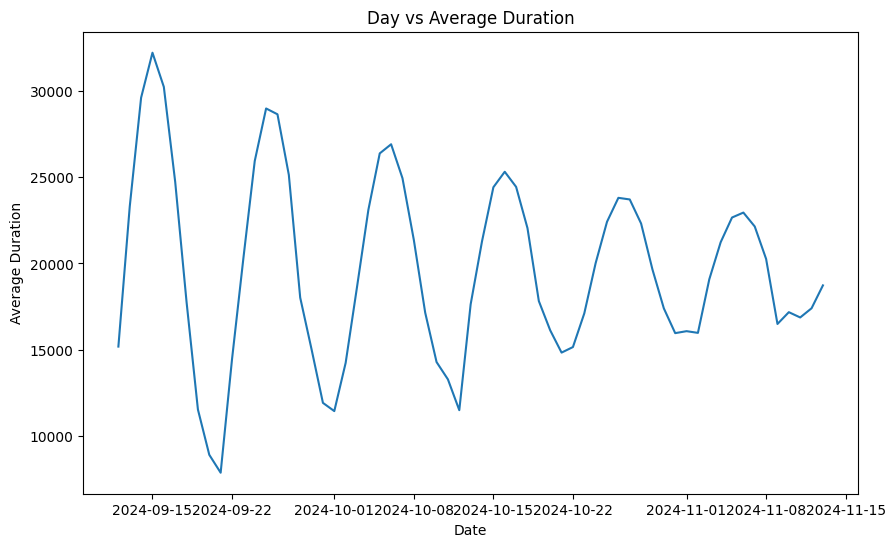

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(paired_data_days.index, paired_data_days.values)
plt.xlabel('Date')
plt.ylabel('Average Duration')
plt.title('Day vs Average Duration')
plt.show()

#### Scaling the data

In [25]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(paired_data_days.values.reshape(-1, 1))
scaled_data = pd.DataFrame(scaled_values, columns=['duration'])
scaled_data.index = paired_data_days.index
scaled_data

,duration
date,
2024-09-12,0.300330
2024-09-13,0.633681
2024-09-14,0.892936
2024-09-15,1.000000
2024-09-16,0.918622
...,...
2024-11-09,0.354156
2024-11-10,0.382261
2024-11-11,0.369650


In [41]:
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

X = scaled_data.values
size = int(len(X) * 0.7)
train, test  = X[0:size], X[size:len(X)]

#### Training the data with order = (3,1,1)

In [40]:
history = [x for x in train]
predictions1 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    temp  = output[0]
    predictions1.append(temp)
    obs = test[t]
    history.append(obs)
print(mean_absolute_error(test, predictions1))


0.0236490065444274


In [45]:
unscaled_predictions = scaler.inverse_transform(np.array(predictions1).reshape(-1, 1))
unscaled_test = scaler.inverse_transform(test)
unscaled_train = scaler.inverse_transform(train)

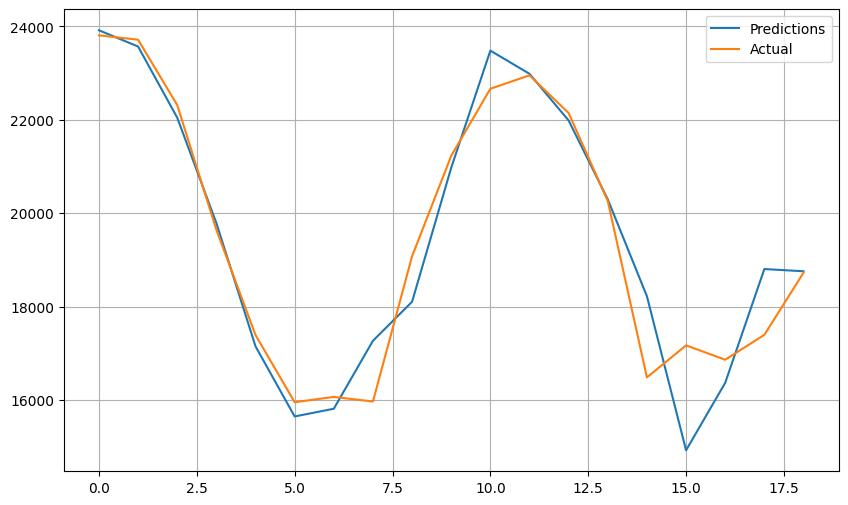

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(unscaled_predictions, label='Predictions')
plt.plot(unscaled_test, label='Actual')
plt.grid(True)
plt.legend()
plt.show()

In [46]:
print("MAPE: ", mean_absolute_percentage_error(unscaled_test, unscaled_predictions))
print("MASE: ", MASE(unscaled_test.reshape(1, -1)[0], unscaled_predictions.reshape(1, -1)[0], unscaled_train.reshape(1, -1)[0]))

MAPE:  3.2523466994611434
MASE:  0.17336492819732105


### Forecasting data with the second method i.e replacing themissing values with forward fill



In [47]:
final_df['date'] = final_df['timestamp'].dt.date
final_df_days = final_df.groupby('date')['duration'].mean()
final_df_days

date
2024-09-12    15161.173815
2024-09-13    23302.843016
2024-09-14    29620.465116
2024-09-15    32222.180801
2024-09-16    30239.145907
                  ...     
2024-11-09    16520.816327
2024-11-10    17150.847458
2024-11-11    16853.623188
2024-11-12    17398.511166
2024-11-13    18732.906530
Name: duration, Length: 63, dtype: float64

#### Graph after smoothning

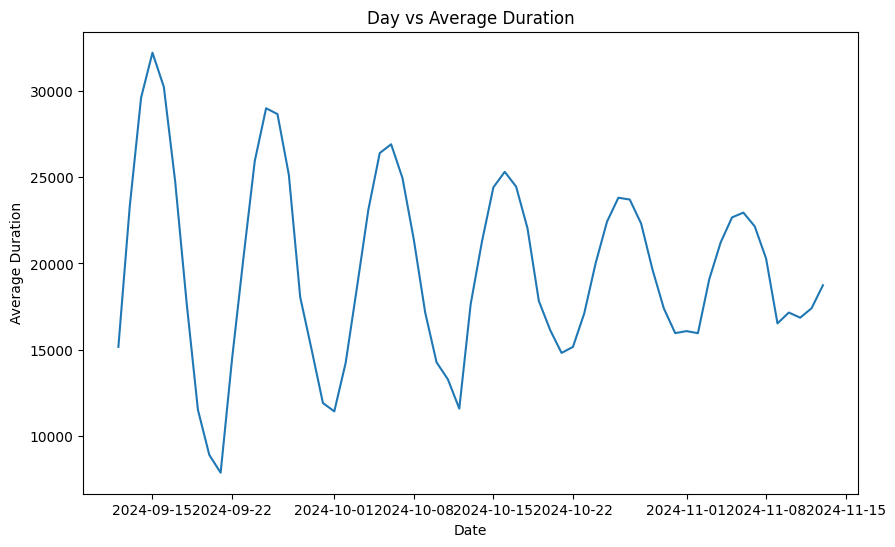

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(final_df_days.index, final_df_days.values)
plt.xlabel('Date')
plt.ylabel('Average Duration')
plt.title('Day vs Average Duration')
plt.show()

In [48]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(final_df_days.values.reshape(-1, 1))
scaled_data = pd.DataFrame(scaled_values, columns=['duration'])
scaled_data.index = final_df_days.index
scaled_data

,duration
date,
2024-09-12,0.299707
2024-09-13,0.633893
2024-09-14,0.893209
2024-09-15,1.000000
2024-09-16,0.918603
...,...
2024-11-09,0.355515
2024-11-10,0.381376
2024-11-11,0.369176


In [50]:
X = scaled_data.values
size = int(len(X) * 0.7)
train, test  = X[0:size], X[size:len(X)]

In [52]:
history = [x for x in train]
predictions1 = list()
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    temp  = output[0]
    predictions1.append(temp)
    obs = test[t]
    history.append(obs)
print(mean_absolute_error(test, predictions1))

0.02352990772610931


In [53]:
unscaled_predictions = scaler.inverse_transform(np.array(predictions1).reshape(-1, 1))
unscaled_test = scaler.inverse_transform(test)
unscaled_train = scaler.inverse_transform(train)

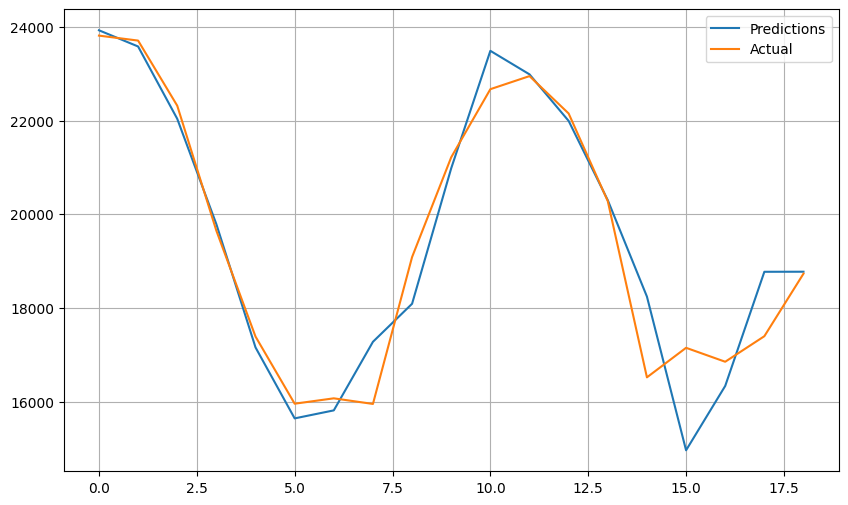

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(unscaled_predictions, label='Predictions')
plt.plot(unscaled_test, label='Actual')
plt.grid(True)
plt.legend()
plt.show()

In [56]:
print("MAPE: ", mean_absolute_percentage_error(unscaled_test, unscaled_predictions))
print("MASE: ", MASE(unscaled_test.reshape(1, -1)[0], unscaled_predictions.reshape(1, -1)[0], unscaled_train.reshape(1, -1)[0]))

MAPE:  3.2338475891165857
MASE:  0.17231581778569224
